In [1]:
import os, sys
import inspect
from IPython.display import Markdown, display
repo_path = os.path.abspath(os.path.join(os.getcwd(), '../../..'))
code_path = os.path.abspath(os.path.join(repo_path, "code/src"))
os.chdir(os.path.join(repo_path))
if code_path not in sys.path:
    sys.path.append(code_path)

# Table of contents

1. [Background](#background)
    1. [*Streptococcus Pneumoniae*](#spneu)
    2. [Modelling Framework](#framework)
        1. [Transmission model](#transmission)
        2. [Demography](#demography)
2. [Installing the module](#installation)
3. [Model structure](#s_structure)
    1. [Run Scenarios](#s_run_scenarios)
    2. [Model](#s_model)
        1. [Disease](#s_disease)
        2. [Population](#s_population)
        3. [Observers](#s_observers)
    3. [Utils](#s_utils)
    4. [Code guide](#s_code_guide)
4. [Run an example simulation](#run_simulation)



# 1. Background  <a name="background"></a>

## 1.1. *Streptococcus Pneumoniae*  <a name="spneu"></a>
*Streptococcus pneumoniae* (*S. pneumoniae*) causes respiratory infections which can then lead to non-invasive disease—such as otitis media and pneumonia—or invasive pneumococcal disease (IPD), including meningitis and bacteraemia (Yildirim et al., 2010; Hausdorff et al., 2005). There are over 100 pneumococcal serotypes with varying prevalence by age and geographic location (Bertran et al., 2024; Hausdorff et al., 2005). Immunogenicity characteristics—such as the immunoglobulin G (IgG) concentration required for protection and potential to cause invasive disease—also vary by serotype (Andrews et al., 2014; Feng et al., 2024; Hausdorff et al., 2005). 

Highest burden of morbidity and mortality caused by pneumococcus is mostly observed in low- and middle-income countries, and disproportionately affects children (Wunrow et al., 2023; Wahl et al., 2018). Due to the high burden of disease, several pneumococcal vaccines has been developed and administered with varying vaccine schedules globally (Bertran et al., 2024; Feng et al., 2024; Musher et al., 2022).

There are two main oneumococcal vaccine categories: pneumococcal polysaccharide vaccines (PPVs) and pneumococcal conjugate vaccines (PCVs). It is assumed that PPVs provide protection against IPD, however, they show limited and variable efficacy in preventing community-acquired pneumonia (CAP) and do not provide protection against transmission (Moberley et al., 2013).

PCVs enhance immunogenicity and effectiveness by inducing immune memory, including in young children (Musher et al., 2022). Conjugate vaccines protect against both infection and developing disease (O’Brien et al., 2007; Feemster et al., 2024). A seven-valent conjugate vaccine (7vPCV), first licensed in the USA in 2000 (Hausdorff et al., 2005; O’Brien et al., 2007). Serotype replacement and persistent burden of disease observed post-7vPCV introduction have lead to the development of higher-valency vaccines including a 13-valent PCV (13vPCV), a 15-valent PCV (15vPCV), a 20-valent PCV (20vPCV), and a 21-valent PCV (21vPCV) (Wunrow et al., 2023; Musher et al., 2022; Feemster et al., 2024; O’Brien et al., 2007). However, there is concern regarding declining immunogenicity against shared serotypes with higher-valency PCVs, with uncertain implications for effectiveness (Feemster et al., 2024).

Variability in serotype-specific immunogenic responses among multiple vaccine products requires a flexible approach to modelling the potential impacts of different vaccines. While previous models examining pneumococcal vaccines account for the multi-serotype nature of *S. pneumoniae* to some degree, they often depend on simplifying assumptions related to serotypes (e.g., vaccine-type groupings, restricted serotype sets), co-infections (e.g., assuming no co-infections within vaccine-type groups), immune response (e.g., homogeneous responses), and host representation (e.g., single-age-group focus) (Melegaro & Edmunds, 2004; De Cao et al., 2014; Wasserman et al., 2018; Choi et al., 2019; Choi et al., 2012; Flasche et al., 2013; Megiddo et al., 2018).

For example, models that group serotypes into vaccine and non-vaccine types typically assume no co-infection within each serotype group, which prevents co-infection with two non-vaccine serotypes (e.g., De Cao et al., 2014). This assumption can alter transmission dynamics once vaccine-type serotype circulation decreases following vaccine introduction. Additionally, these models often assume a homogeneous vaccine-induced immune response across all vaccine-type serotypes (e.g., Megiddo et al., 2018), preventing incorporation of observed serotype-specific immunogenicity differences. These assumptions limit the exploration of vaccine program effectiveness and the impact of reduced immunogenicity of higher-valency vaccines.

We developed a flexible individual-level modelling framework that incorporates differences in vaccine immunogenicity across individual serotypes, allowing estimation of relative correlates of protection using historical data. The manuscript that explains the model in more detail is avaiable as a preprint: [Tellioglu et al.](https://www.medrxiv.org/content/10.1101/2025.05.22.25327965v4). This guide explains the structure and contents of the code repository that includes the modelling framework.

## 1.2. Modelling Framework  <a name="framework"></a>
This repository includes an individual-based model that incorporates demographic and transmission dynamics of *Streptococcus pneumoniae*. Each serotype is represented individually. We assume a susceptible-infectious-susceptible (SIS) model for *S. pneumoniae* infection, where “infection” represents carriage of *S. pneumoniae* (infectious symptomatic or asymptomatic colonisation of the nasopharynx by *S. pneumoniae*), and disease outcomes are considered for the infected individuals. 


### 1.2.1. Transmission model <a name="transmission"></a>
Our modelling framework is comprised of three integrated models (Fig 1).The model incorporates assumptions about mixing and carriage. In this section, we outline these assumptions and describe the clinical model and vaccine rollout in detail.

<p align="center">
  <img src="images/modelling_diagram.png" alt="Fig 1: Modelling framework" width="800">
  <br>
  <b>Fig 1:</b> Modelling framework
</p>

##### Mixing assumptions
Transmission within and between age groups is driven by contact rates, derived from synthetic contact matrices. In this work, we have assumed contacts in our population according to the contact matrices provided by Prem et al. (2017).

#####  Carriage assumptions
Similar to previous modelling studies, the infectious duration for an individual is sampled from an exponential distribution with an age-specific mean infectious duration. Upon recovery, infectious individuals re-enter the susceptible class, with protection derived from antibodies according to the time since their last vaccination. 

Carriage of serotypes is determined in multiple steps (Fig 2). We first determine if individuals will be exposed to any serotype, we then determine the serotype, then assess the individual’s serotype-specific vaccine-induced antibody levels and existing infections, to determine if carriage of the serotype occurs in the individual. 

<p align="center">
  <img src="images/infection_flowchart.png" alt="Fig 2: Flowchart of acquiring a serotype" width="800">
  <br>
  <b>Fig 2:</b> Flowchart of acquiring a serotype
</p>

Individual infection risk in a time step is determined by serotype prevalence, age, contact rates, current infection status and current antibody levels:
$$
Pr(\text{Exposure to any serotypes}) = (1 - e^{-\text{foi}_i}) 
$$

where:

- $\text{foi}_i$ = Force of infection on an individual in age class $i$

The force of infection comprises age-specific community transmission:

$$
\text{foi}_i = q \sum_s \tau_s \left( \sum_j \frac{\eta_{ij} * I_{js}}{N_j} \right)
$$

where:

- $q$ = Transmission coefficient  
- $\tau_s$ = Transmission coefficient multiplier of serotype $s$  
- $\eta_{ij}$ = Number of daily community contacts between an individual in age group $i$ and individuals in age group $j$  
- $I_{js}$ = Number of individuals in age group $j$ infected with serotype $s$  
- $N_j$ = Number of individuals in age group $j$  

We assume that an individual can be only infected by a single serotype at every time step. The exposed serotype, serotype a, is randomly selected from weighted distribution of prevalences of individual serotypes in the population. We then check whether the individual is going to get infected by *S. pneumoniae* serotype a by checking the individual’s vaccine-induced antibody levels and existing infections:

$$
Pr(\text{Infection by serotype a | Exposure to serotype a}) = V_a \, * C
$$

where:

- $V_a$ = Vaccine-induced probability of acquisition multiplier to serotype $a$
- $C$ = Reduction of susceptibility given existing infections

If the individual does not have any vaccine-induced antibody levels to serotype $a, V_a$  is set as 1. In addition, we assume that 23vPPV is not effective against acquisition. We allow co-infections in the model assuming that individuals may be infected with multiple serotypes concurrently, with a reduced probability of acquiring another serotype if already infected, representing within-host competition. In this work, we assumed that $C$ takes values of 1 (fully susceptible), 0.8, and 0 for the existing number of infections of 0, 1, and 2, respectively, which means that individuals could only be infected with two serotypes concurrently. $C$ is assigned by two parameters: 'reduction_in_susceptibility_coinfections' and 'max_no_coinfections' which are set as 0.8 and 2, respectively. Parameter 'max_no_coinfections' can be set as higher values, however, in order to incorporate values other than 2 when population is going to be saved post simulation, population must be saved in a parquet file rather than 3 separate csv files. Current version of population recording assumes that individuals can have up to two co-infections. In addition, 'reduction_in_susceptibility_coinfections' only checks whether current number of co-infections is higher than one. Therefore, there is no additional reduction in sussceptibility if individual is already infected by two or more serotypes.  

##### Clinical model

The clinical model takes information on the age and vaccine history of newly infected individuals from the transmission model, and the antibody levels at the time of infection, derived from these values, from the immunity model. Disease outcomes (IPD or hospitalised CAP) are calculated at every time step. The new cases are recorded in P.disease_pop which is a pl.DataFrame that is restarted as a a new DataFrame at every year. This reinitialisation does not affect the transmission dynamics as it is assumed that developing disease do not have an impact on the transmission dynamics. In this work, we assume that 23vPPV is not effective against developing CAP, therefore, we separate individuals vaccinated by 23vPPV in the clinical model (Fig 3). 

<p align="center">
  <img src="images/disease_flowchart.png" alt="Fig 2: Flowchart of developing disease" width="800">
  <br>
  <b>Fig 2:</b> Flowchart of developing disease
</p>


We assume that an individual can develop disease only once from a given infection with a single serotype. Therefore, we first remove individuals who have already developed disease during a specific infection period. We check if the infected individual has vaccine-induced antibody levels against their infecting serotypes. Then, by using the probability of developing disease formulation, individual’s vaccine-induced antibody levels (zero if the individual is unvaccinated or the infecting serotype is not included in their vaccine type) and age, individuals risk status, severity multiplier of serotype a, the model determines whether an infected individual develops a disease outcome.  Then the clinical model decides whether the outcome is IPD or CAP based on the relative probability provided by `ipd_fraction_by_age_group` parameter of the Disease class.




##### Vaccine Rollout
The model simulates the implementation of historical vaccine schedules with their rollout years, eligible age range, annual fraction of on-time and late vaccine coverages of the eligible age group, number of doses and time interval between doses. We make two assumptions:
- Individuals receiving the first dose on time would also receive the following doses on time. 
- Maximum protection by a vaccine starts immediately.
These two assumptions are hard coded. In order to make changes, `check_vaccines()` function must be updated.

#####  Single time step update of disease dynamics
At every time step, disease transmission is updated in the update() function of a disease class based on the following order: 

- vaccine rollout (in check_vaccines function), 
- checking disease transmission, recovery, and disease outcomes (in check_exposure function), 
- checking external exposure to the community (in external_exposure function), 
- updating individuals states (in update_ind_states function). 
- Finally, observes that collect summary statistics are updated (in update_observers function)


### 1.2.2. Demography <a name="demography"></a> 
The model includes births, ageing, age-specific mortality, and age-specific migration to capture the age distribution of a population over time. It takes inputs of initial population size, initial age distribution, age-specific death rates, annual net birth rates, annual migration rates, and age distribution in the emigrated population to simulate demographic dynamics. We sourced the inputs from Australian Bureau of Statistics and Macro Trends Global to align with Australian population dynamics and record the data in the data folder. In oder to use the model for other populations, the following parameters in the params.py script should be changed:
| Parameter                     | Value or File                                | Notes |
|-------------------------------|---------------------------------------------|-------|
| `age_distribution`            | `population/age_dist_2002.dat`              | Initial age distribution |
| `initial_death_rates`         | `population/death_rates_2002.dat`           | Death rate used at the start |
| `later_death_rates`           | `None`                                      | Death rate can be updated later (e.g., `'death_rates_2008.dat'` from 2008) |
| `year_to_change_death_rates`  | `6`                                         | If `later_death_rates` is not `None`, update starts at this year |
| `birth_rates`                 | `population/birth_rates.dat`                | Birth rates file |
| `mig_rates`                   | `population/migration_rates.dat`            | Migration rates file |
| `age_distribution_mig`        | `population/age_dist_migration_2018.dat`    | Age distribution of the emigrating population |


# 2. Installing the module <a name="installation"></a>
The module installation is described in [README.md](../../../README.md) file. The module must be install through terminal:
```shell
python3 -m venv venv
source venv/bin/activate
# set working directory as code repository then
pip install -e .
```

# 3. Repo structure <a name="s_structure"></a> 

The repository that simulates pneumococcal transmission in an aged-structured population is structured as the following: 

1. [Model](#s_model)
    1. [Disease](#s_disease)
    2. [Population](#s_population)
    3. [Observers](#s_observers)
2. [Utils](#s_utils)
3. [Code guide](#s_code_guide)
4. [Run scenarios](#s_run_scenarios)


The scripts in [run scenarios](#s_run_scenarios) folder takes a model from [model](#s_model) folder and runs single or batch runs (with helper functions taken from [utils](#s_utils) folder). The model is structured in three subfolders: 

* [disease](#s_disease) folder stores disease model and disease simulation classes,
* [population](#s_population) folder stores population classes,  
* [observers](#s_observers) folder stores scripts to collect summary statistics.  


### 3.1. Model <a name="s_model"></a>

The main function that is called from Model folder is `go_single()` function located in [varying_transmission_run.py](../model/disease/varying_transmission_run.py) which simulates both disease and demographical dynamics in the update function of the simulation class. Here we list the docstring of go_single function and provide descriptions of each input in a table.

```python

def go_single(p = parameters, 
            disease_type = VaryingTransmissionDisease, 
            cmatrix = KnownContactMatrix, 
            cur_seed = 1234, 
            sim_type = VaryingTransDisSimulation, 
            verbose=False):
    """
    Run a single simulation (or load if previously run).
    :param p: The simulation parameters
    :type p: dict
    :param disease_type: The disease model to simulate.
    :type disease_type: :class:`DiseaseBase`
    :param cmatrix: The population contact matrix.
    :type cmatrix: :class:`ContactMatrix`
    :param cur_seed: Random seed for current experiment.
    :type cur_seed: int
    :param sim_type: Simulation class to use (current options are SimEpi or SimBDI).
    :type sim_type: :class:`SimEpi`
    :param verbose: Flag to indicate whether to write output to terminal.
    :type verbose: bool
    """
```
Table: go_single() function  and its input parameters
| Function / Class                  | Script                    | Inputs from other scripts/Notes        |
|----------------------------------|-------------------|------------------------------------------------|
| `go_single()`                    | [varying_transmission_run.py](../model/disease/varying_transmission_run.py)  | Takes a simulation class (with pre-define population class inside simulation script), a disease class, a contract matrix class, and a parameter set |
| `DisSimulation`  or `VaryingTransDisSimulation`  |[disease_simulation.py](../model/disease/disease_simulation.py) or [varying_transmission_disease_simulation.py](../model/disease/varying_transmission_disease_simulation.py)    | Simulation class; simulates demographic dynamics and disease transmission model.|
| `Disease(object)` or `VaryingTransmissionDisease(Disease)` | [disease.py](../model/disease/disease.py) or  [varying_transmission_disease.py](../model/disease/varying_transmission_disease.py) |Keeps functions to simulate multi-strain pathogen transmission in a population with age structure.  |
|`KnownContactMatrix(object)`| [contact_matrix.py](../model/disease/contact_matrix.py) | Contact matrix class that generates a matrix class from a given matrix csv file.  |



### 3.1.1. Disease <a name="s_disease"></a>
In this section, we describe the classes included in the disease folder. We then outline each Python script in the folder and highlight the main functions of the disease classes that are useful for understanding how the disease is simulated.

Following classes are included in different scripts in disease folder:

Table: List of classes in disease folder
| Class Name        | Script | Description |
|----------------------|-------------|-------------|
| `Disease(object)`| [disease.py](../model/disease/disease.py) | Class to keep functions to simulate multi-strain pathogen transmission in a population with age structure. The list of main functions are provided in the following table. |
| `| `Disease(object)` or `VaryingTransmissionDisease(Disease)` | [disease.py](../model/disease/disease.py) or  [varying_transmission_disease.py](../model/disease/varying_transmission_disease.py) |Keeps functions to simulate multi-strain pathogen transmission in a population with age structure.  |
(Disease)`| [varying_transmission_disease.py](../model/disease/varying_transmission_disease.py) | The only difference from Disease class above is that it includes serotype-specific transmission multipliers in serotype transmission. |
| `DisSimulation(Simulation)`| [disease_simulation.py](../model/disease/disease_simulation.py) | Simluation class that takes a disease class as an input and simulates both disease and demographical dynamics. |
| `VaryingTransDisSimulation(DisSimulation)`| [varying_transmission_disease_simulation.py](../model/disease/varying_transmission_disease_simulation.py) | Simluation class that takes a disease class as an input and simulates both disease and demographical dynamics. The demographical updates include births, deaths, aging, immigration. It makes the demographical and disease related updates in DisPopulation class object. In _main_loop(), it updated demography (if True) and disease transmission and save the population (if True) when the simulation ends. Currently population is saved in three different csv files due to the nested struct columns of list of strains (_strain_list.csv) and corresponding time until clearance (_endList.csv) and the rest of the columns. This saving section can be later updated by using write_parquet() function of polars library which can write nested columns into the same file. The only downside would be that the saved parquet files cannot be opened by excel for an easy review of the dataset.|
| `KnownContactMatrix(object)`| [contact_matrix.py](../model/disease/contact_matrix.py) | Contact matrix class that generates a matrix class from a given matrix csv file. KnownContactMatrix class is then given as an input to go_single() function |

Following scripts are included in disease folder:

| Script | Class / Function | Description |
|--------|-----------------|------------|
| [antibody_levels.py](../model/disease/antibody_levels.py) | `create_vaccine_antibody_df()`,  `waning_ratio()` | Creates vaccine-induced serotype, vaccine, and dose-specific antibody levels and estimates waning of initial antibody levels. |
| [disease.py](../model/disease/disease.py) | `Disease`, `DiseaseModel` | `Disease` class is a main input for `go_single()`. `DiseaseModel` takes observers from [observers](../model/observers) to collect summary statistics. Main functions of `Disease` class is provided in the table below. |
| [varying_transmission_disease.py](../model/disease/varying_transmission_disease.py) | `VaryingTransmissionDisease` | Extends `Disease` class by including transmission multipiers to individuals in carriage transmission. Main functions listed in the table below. |
| [varying_transmission_disease_simulation.py](../model/disease/varying_transmission_disease_simulation.py) | `VaryingTransDisSimulation` | Simulates disease and demographic dynamics using a disease class and `DisPopulation` as input. |
| [contact_matrix.py](../model/disease/contact_matrix.py) | `KnownContactMatrix` | Generates a contact matrix from a CSV file; used as input to `go_single()`. |
| [disease_simulation.py](../model/disease/disease_simulation.py) | `DisSimulation` | Simulates disease and demographic dynamics from a disease class; main input to `go_single()`. Docstring provided below. |
| [disease_utils.py](../model/disease/disease_utils.py) | `gen_age_structured_pop()` | Helper function to generate age-structured population columns. |
| [run.py](../model/disease/run.py) | `go_single()` | Simulates disease and demographic dynamics using a disease class, a simulation class, contact matrix, and parameters. |
| [varying_transmission_run.py](../model/disease/varying_transmission_run.py) | `go_single()` | Similar to `run.py` but uses VaryingTransDisSimulation class. |


Here are the main functions of the disease class that are useful for the transmission and disease dynamics:

Table: Main functions of Disease class
| Function Name        | Description |
|----------------------|-------------|
| `check_exposure()`   | Simulates the transmission mechanisms of the disease classes as described above. |
| `check_recoveries()` | Once an individual's carriage end time is reached, the serotype is removed from their `strain_list`. This function is called within `check_exposure()`, but it can be moved outside if needed. |
| `external_exposure()`| Introduces serotypes externally via two processes: (1) migration-driven introduction based on local age- and serotype-specific carriage, and (2) uniform sampling of any possible serotype, enabling serotype replacement. |
| `external_exposure()`| Introduces serotypes externally via two processes: (1) migration-driven introduction based on local age- and serotype-specific carriage, and (2) uniform sampling of any possible serotype, enabling serotype replacement. |
| `check_disease()`| Disease outcomes (IPD or hospitalised CAP) are calculated at every time step. The new cases are recorded in P.disease_pop which is a pl.DataFrame that is restarted as a a new DataFrame at every year. This reinitialisation does not affect the transmission dynamics as it is assumed that developing disease do not have an impact on the transmission dynamics. `check_disease()` is currently called in `check_exposure()` but it can be moved outside of `check_exposure()` function.|
| `check_vaccines()`| At every time step, it checks each vaccine whether it's time to vaccinate individuals. If so, it identifies individuals who are going to vaccinated on time or late. For the "on time" vaccinations, it update individuals vaccine status and records "no of doses", "final vaccine type", "final vaccination time" in the individuals "vaccine" struct column. It identify individuals who are going to receive vaccination late in the upcoming time steps and assing "final_vaccination_time" as a negative "time_to_vaccinate" value. Later it checks individuals who are going to receive their late vaccination in current time by identifying individuals who have negative current time step in their "final vaccination time" column. The function is quite long and it needs to be seperated into different chunchs and they must be carried into "vaccine.py" for readability. The reason for the long function is that different types of vaccines has different conditions in their targeted group.|



### 3.1.2. Population <a name="s_population"></a>

The population class includes `DisPopulation(Population)` class as well as includes births, ageing, age-specific mortality, and age-specific migration to capture the age distribution of a population over time. It takes inputs of initial population size, initial age distribution, age-specific death rates, annual net birth rates, annual migration rates, and age distribution in the emigrated population to simulate demographic dynamics. We sourced the inputs from Australian Bureau of Statistics and Macro Trends Global to align with Australian population dynamics. 

Following scripts are included in population folder:
| Script | Class / Function | Description |
|--------|-----------------|------------|
|[disease_population.py](../model/population/disease_population.py)|`DisPopulation(Population)`|Compared to the Population class, DisPopulation also includes vaccines struct column (consisting of no_of_doses, on_time, vaccine_type, final_vaccine_time), as well as strain columns including no_of_strains, strain_list, endTimes (time to end each infection), no_past_infections.`class DisPopulation(Population)` can upload population files stored in [saved_checkpoints](../../../data/saved_checkpoints) Folder.|
|[population.py](../model/population/population.py)|`Population(Object)`|The base population class for a population containing pl.dataFrame where each row represent an individual. The base population class does not include any disease or vaccine related columns. |
|[simulation.py](../model/population/simulation.py)|`Simulation(Object)`|It inlcudes  that simulates demographical dynamics of a given population. DisSimulation or AtRiskDisSimulation classes in the disease folder are extended versions of the Simulation class.|
|[utils.py](../model/population/utils.py)|-|Keeps helper functions used Simulation() class to simulate demographical dynamics such as  load_age_rates(), load_probs,load_prob_list(), gen_age_structured_pop(), will_live().|

### 3.1.3. Observers <a name="s_observers"></a>

 In order to add remove observers the changes must be made to `DiseaseModel` class in `...disease_model.py` script. In order to create more observers or edit existing observers, changes must be made in the [observers](../model/observers) folder.

 Following scripts are included in population folder:
| Observer Class | Script | Description |
|----------------|--------|-------------|
| **Observer (base class)** | [obs_base.py](../model/observers/obs_base.py) | Base observer class with `create_storage()`, `load_storage()`, and `update()` functions. |
| **DiseaseObserverByAgeByProduct** | [obs_disease_by_age_by_product_at_risk.py](../model/observers/obs_disease_by_age_by_product_at_risk.py) | Records individuals by age across infection, disease, vaccination history (ever, last 1 year, last 5 years), and vaccine product. |
| **DiseaseObserverByAge** | [obs_disease_by_age.py](../model/observers/obs_disease_by_age.py) | Records serotype-group–specific IPD and CAP outcomes by age. |
| **PopulationObserver** | [obs_pop.py](../model/observers/obs_pop.py) | Records population size and median age. |
| **PrevalenceByAgeObserver** | [obs_prevalence_by_age.py](../model/observers/obs_prevalence_by_age.py) | Records total individuals, total infected individuals, and total infections by age at every timestep. |
| **PrevalenceByAgeObserver (extended)** | [obs_prevalence_mult_age_groups.py](../model/observers/obs_prevalence_mult_age_groups.py) | Records individuals, infected individuals, infection fractions, and strain-specific infections in predefined age groups. |
| **PrevalenceByAgeObserver (modified)** | [obs_prevalence.py](../model/observers/obs_prevalence.py) | Records total individuals, total infected individuals, and infection fractions in selected age groups. |
| **VaccinationDeliveredObserver** | [obs_vacc_delivered.py](../model/observers/obs_vacc_delivered.py) | Records vaccines delivered each timestep by type and total population size. |
| **VaccinationEffAcquisitionObserver** | [obs_vacc_efficacy_against_acq.py](../model/observers/obs_vacc_efficacy_against_acq.py) | Records vaccinated individuals’ antibody levels, exposed serotype, and whether infection occurs (from `P.vaccinated_acq_pop`). |
| **VaccinationEffDiseaseObserver** | [obs_vacc_efficacy_against_disease.py](../model/observers/obs_vacc_efficacy_against_disease.py) | Records vaccinated individuals’ antibody levels, exposed serotype, and disease outcomes (from `P.vaccinated_disease_pop`). *Not used; needs update.* |
| **VaccinationObserver (used in scenarios)** | [obs_vacc_rollout_scenarios.py](../model/observers/obs_vacc_rollout_scenarios.py) | For each birth cohort, records vaccination coverage by vaccine product. |
| **VaccinationObserver** | [obs_vacc_rollout.py](../model/observers/obs_vacc_rollout.py) | Same as above but uses different birth cohorts. |
| **VaccineObserverByAgeByProduct** | [obs_vaccine_by_age_by_product_at_risk.py](../model/observers/obs_vaccine_by_age_by_product_at_risk.py) | Records age-specific numbers of individuals by vaccine type, at-risk group, time since vaccination (ever/1y/5y), and disease type (IPD, CAP). |


### 3.2. Utils <a name="s_utils"></a>

Utils folder include params_combo.py script which has ParamComboIt class is a helper class to generate batch simulations.

### 3.3. Code guide <a name="s_code_guide"></a>

code_guide folder includes this documentation of the repository.

### 3.4. Run Scenarios <a name="s_run_scenarios"></a>
Table of script interactions in running scenarios is provided below.  `run_....py` scripts are used to run a single or batch runs which eventually calls  `go_single()` function.

Table: Main scripts that are called to run a simulation
| Function or script              | Script                            | Inputs from other scripts               |
|--------------------------------|-------------------------------------|----------------------------------------|
| `run_....py` (main script)     | `run_....py`         | Imports parameter set from `..._params.py`; runs imported `new_go_single()`|
| `new_go_single()`              | [varying_disease_model.py](../run_scenarios/varying_disease_model.py) | Called by `run_....py`. It passes parameters to `go_single()`. |
| `go_single()`  | [varying_transmission_run.py](../model/disease/varying_transmission_run.py) | Receives parameter set via `new_go_single`. It takes a parameter dictionary (p), disease_type (disease class to use), contact matrix, a random seed (int), a simulation type (Simulation class to use) and then runs a single simulation.|
| Parameter set (`params`)   |  [base_params.py](../run_scenarios/base_params.py)    | Loaded by `run_....py`; optionally edited before passed onward.|
| Parameter set (`params`)   |  [base_params.py](../run_scenarios/base_params.py)    | Loaded by `run_....py`; optionally edited before passed onward.|
| `get_prev_data()` and `plot_base_prev()`   |  [plotting_helper_functions.py](../run_scenarios/plotting_helper_functions.py)    | `get_prev_data()` and `plot_base_prev()` are two helper functions to read the output from a saved hd5 file and plot the prevalence of serotypes over one-year time horizon.|

# 4. Run an example simulation <a name="run_simulation"></a>

In this section, we provide details of how to run an example simulation located in [run_varying_disease_model_combo_base_0_18.py](../run_scenarios/run_varying_disease_model_combo_base_0_18.py) script. This script that simulates the transmission in non-Indigenous population of Australia. The script takes parameters from [params.py](../run_scenarios/params.py) script. The scripts can be directly used to run simulations and the parameters can be further edited in the script if needed, ie `p['prefix']` can be set as`'output/example_run'`.

Then given a sweep_params list, a parameter combinations list called `param_combos` is created. The list is then transformed `job_inputs` as a list of tuples in order to be used in parq to run scenarios using multiprocessing.
    
#### Running single simulation
In order to run a single simluation, make sure that script has the following lines at the end:

```python
#run a single simulation among combinations
new_go_single(job_inputs[0][0])
#OR run multiple simulations
#results = parq.run(new_go_single, job_inputs, n_proc=32, results=False)
```

#### Running batch simulations
In order to run a batch of simulations using multiprocessing, given for instance 32 cores, make sure that script has the following lines at the end:

```python
#run a single simulation among combinations
#new_go_single(job_inputs[0][0])
#run multiple simulations
results = parq.run(new_go_single, job_inputs, n_proc=32, results=False)
```

The examplar scenario below runs transmission of serotypes between 2002-2004 and plots prevalence of individual serotypes based on their vaccine groupings.

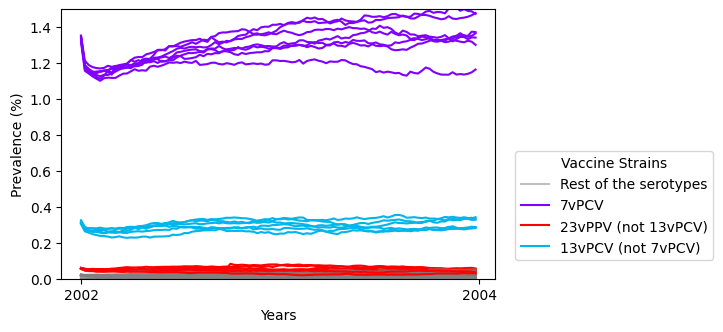

In [2]:
%run code/src/run_scenarios/run_examplar_scenario.py

# References

Yildirim, I., Hanage, W. P., Lipsitch, M., Shea, K. M., Stevenson, A., Finkelstein, J., Huang, S. S., Lee, G. M., Kleinman, K., & Pelton, S. I. (2010). Serotype specific invasive capacity and persistent reduction in invasive pneumococcal disease. *Vaccine, 29*(2–3), 283–288.

Hausdorff, W. P., Feikin, D. R., & Klugman, K. P. (2005). Epidemiological differences among pneumococcal serotypes. *The Lancet Infectious Diseases, 5*(2), 83–93.

Bertran, M., D’Aeth, J. C., Abdullahi, F., Eletu, S., Andrews, N. J., Ramsay, M. E., … Ladhani, S. N. (2024). Invasive pneumococcal disease 3 years after introduction of a reduced 1 + 1 infant 13-valent pneumococcal conjugate vaccine immunisation schedule in England: a prospective national observational surveillance study. *The Lancet Infectious Diseases, 24*, 546–556.

Andrews, N. J., Waight, P. A., Burbidge, P., Pearce, E., Roalfe, L., Zancolli, M., … Goldblatt, D. (2014). Serotype-specific effectiveness and correlates of protection for the 13-valent pneumococcal conjugate vaccine: a postlicensure indirect cohort study. *The Lancet Infectious Diseases, 14*(9), 839–846.

Feng, S., McLellan, J., Pidduck, N., Roberts, N., Higgins, J. P. T., Choi, Y., … Voysey, M. (2024). Immunogenicity and seroefficacy of pneumococcal conjugate vaccines: a systematic review and network meta-analysis. *Health Technology Assessment*, 1–109.

Wunrow, H. Y., Bender, R. G., Vongpradith, A., Sirota, S. B., Swetschinski, L. R., … Kyu, H. H. (2023). Global, regional, and national burden of meningitis and its aetiologies, 1990–2019: a systematic analysis for the Global Burden of Disease Study 2019. *The Lancet Neurology, 22*, 685–711.

Wahl, B., O’Brien, K. L., Greenbaum, A., Majumder, A., Liu, L., Chu, Y., … Knoll, M. D. (2018). Burden of Streptococcus pneumoniae and Haemophilus influenzae type b disease in children in the era of conjugate vaccines: global, regional, and national estimates for 2000–15. *The Lancet Global Health, 6*, e744–e757.

Musher, D. M., Anderson, R., & Feldman, C. (2022).The remarkable history of pneumococcal vaccination: an ongoing challenge. *Pneumonia, 14*, 5.

Moberley, S., Holden, J., Tatham, D. P., & Andrews, R. M. (2013). Vaccines for preventing pneumococcal infection in adults. *Cochrane Database of Systematic Reviews, 2013*.

Feemster, K., Buchwald, U. K., Banniettis, N., Joyce, J. G., Velentgas, P., Chapman, T. J., & Yildirim, I. (2024). Immunogenicity of current and next-generation pneumococcal conjugate vaccines in children: current challenges and upcoming opportunities. *Open Forum Infectious Diseases, 11*, 1–9.

O’Brien, K. L., Millar, E. V., Zell, E. R., Bronsdon, M., Weatherholtz, R., Reid, R., … Santosham, M. (2007). Effect of Pneumococcal Conjugate Vaccine on Nasopharyngeal Colonization among Immunized and Unimmunized Children in a Community-Randomized Trial. *Journal of Infectious Diseases, 196*, 1211–1220.

Melegaro, A., & Edmunds, W. J. (2004). The 23-valent pneumococcal polysaccharide vaccine. Part I. Efficacy of PPV in the elderly: a comparison of meta-analyses. *European Journal of Epidemiology, 19*, 353–363.

De Cao, E., Melegaro, A., Klok, R., & Postma, M. (2014). Optimising Assessments of the Epidemiological Impact in the Netherlands of Paediatric Immunisation with 13-Valent Pneumococcal Conjugate Vaccine Using Dynamic Transmission Modelling. *PLoS ONE, 9*, e89415.

Wasserman, M., Lucas, A., Jones, D., Wilson, M., Hilton, B., Vyse, A., … Farkouh, R. (2018). Dynamic transmission modelling to address infant pneumococcal conjugate vaccine schedule modifications in the UK. *Epidemiology & Infection, 146*, 1797–1806.

Choi, Y. H., Andrews, N., & Miller, E. (2019). Estimated impact of revising the 13-valent pneumococcal conjugate vaccine schedule from 2+ 1 to 1+ 1 in England and Wales: A modelling study. *PLoS Medicine, 16*, e1002845.

Choi, Y. H., Jit, M., Flasche, S., Gay, N., & Miller, E. (2012). Mathematical modelling long-term effects of replacing Prevnar7 with Prevnar13 on invasive pneumococcal diseases in England and Wales. *PLoS ONE, 7*, e39927.

Flasche, S., Edmunds, W. J., Miller, E., Goldblatt, D., Robertson, C., & Choi, Y. H. (2013). The impact of specific and non-specific immunity on the ecology of Streptococcus pneumoniae and the implications for vaccination. *Proceedings of the Royal Society B, 280*.

Megiddo, I., Klein, E., & Laxminarayan, R. (2018). Potential impact of introducing the pneumococcal conjugate vaccine into national immunisation programmes: an economic-epidemiological analysis using data from India. *BMJ Global Health*.

Tellioglu, N., Price, D., Chen, X., ... McVernon, J. (2025) A flexible agent-based modelling framework of multi-serotype pneumococcal carriage to evaluate vaccine strategies in large populations, medRxiv, 2025.05.22.25327965